# Introduction

Task: having `dsgn` set as our objective, find most optimal choice of elements using the material bank dataset and new elements. 

Optimization should take into account:
*   technical feasibility - element can't be shorter or have smaller area than  required
*   minimization of waste volume, expressed in terms of LCA
*   price, assuming  that we pay for whole elements and don't sell scrap waste.



# Input data

### Abbreviations

dsgn - New Design

bank - Material Bank (collection of preowned, available elements)

LCA - Life Cycle Assessment - Global Warming Potential (GWP) expressed in kilograms of CO2 equivalent of all the emited green-house gases (kgCO2e). 

### Input assumptions
First assumption is that we only consider timber. Steel or concrete could yield more significant savings due to their high carbon footprint. 

In [331]:
NEW_PRICE = 8000    # [NOK/m3], based on average from https://www.byggmax.no/catalogsearch/result/?q=KONSTRUKSJONSVIRKE
NEW_LCA_GWP_A1_A3 = 28.9 # [kgCO2e/m3], assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_LCA_GWP_A5 = 1.59   # [kgCO2e/m3], assuming 'fossil GWP' and 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
NEW_DISTANCE = 100  # [km], maybe it should be variable e.g. 0-500km, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html

DENSITY = 491                 # [kg/m3], assuming 16% moisture, based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
TRANSPORT_LCA_GWP = 0.0318    # [kgCO2e/km], assuming 45% (90% and 0% back) utilisation of 34t truck, burning 0.027 l/tonkm (both ways), based on https://www.epd-norge.no/heltreprodukter/sawn-dried-timber-of-spruce-and-pine-with-an-average-moisture-content-of-16-article4098-320.html
# TRANSPORT_PRICE = ???       # [nok/tonkm], ?

MIN_LENGTH = 1.0    # [m]
MAX_LENGTH = 12.0   # [m]
MIN_AREA = 0.0025   # [m2], 5x5cm
MAX_AREA = 0.125    # [m2], 25x50cm

DSGN_COUNT = 10
BANK_COUNT = 100

BANK_DISTANCE = 100 # [km], maybe it should be variable e.g. 0-500km 
BANK_LCA_GWP_A1_A3 = NEW_LCA_GWP_A1_A3 * 0.0778     # [kgCO2e/m3], based on new product and factor derived from (Eberhardt, 2020)
BANK_LCA_GWP_A5 = NEW_LCA_GWP_A5                    # [kgCO2e/m3], assuming it is the same as for new product
BANK_PRICE = 4000         # [NOK/m3], based on Ormondroyd et al. (2016), where used beam 9"x1.5"x16ft costs 14gbp, so approximately 168 NOK, so a cubic meter appr. 4020nok. TODO: better analysis would be valuable.

\* TODO we need to explain in paper which allocation method for LCA we select. Well described in (Eberhardt, 2020). I assumed for now the most common cut-off, and that we are at the second cycle (even though in Oslo it will be third). I just multiplied the new LCA for EPD product and multiplied by 7/90=0.0778. It is not the correct simplification!

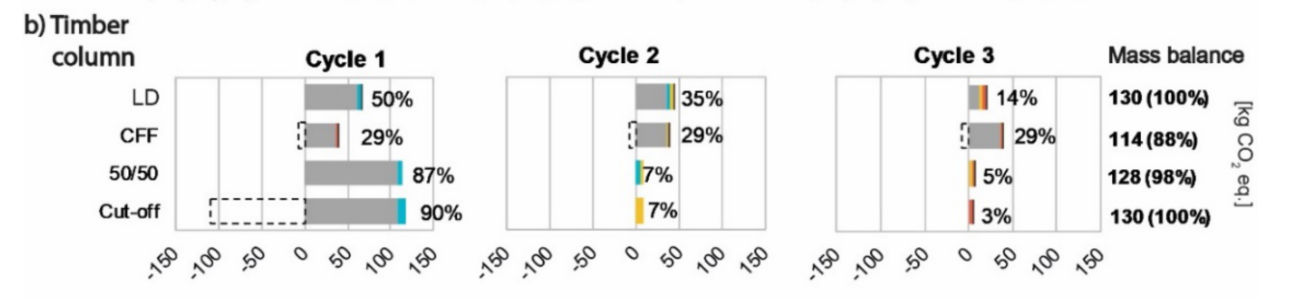

\* TODO other EPDs have other numbers, for example Limtre has 760km distance, 33kg for A1-A3 and 3.2kg for A5: https://www.epd-norge.no/heltreprodukter/limtre-article3247-320.html 

\* TODO we should consult the fossil vs bio approach to GWP calculation with LCA expert. In that EPD the difference is 28.9 vs -741 (2600% better)

\* TODO we should consider implementing more parameters than just GWP:
*  ODP Depletion potential of the stratospheric ozone layer;
*  POCP Formation potential of tropospheric photochemical oxidants;
*  AP Acidification potential of land and water;
*  EP Eutrophication potential;
*  ADPM Abiotic depletion potential for non fossil resources;
*  ADPE Abiotic depletion potential for fossil resources


### Generate pseudorandom numbers
For the material bank:

In [332]:
import pandas as pd
import random

random.seed(3)

bank = pd.DataFrame()
bank['Length'] = [x/10 for x in random.choices(range(int(MIN_LENGTH*10), int(MAX_LENGTH*10)), k=BANK_COUNT)]        # [m], random between the range
bank['Area'] = bank.apply(lambda row: random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA, axis=1)        # [m2], random between the range but dependent on the length of the element
bank['Distance'] = BANK_DISTANCE   # [km], random between 1 and 500 km, maybe it should be variable e.g. 0-500km, random.choices(range(0, BANK_MAX_DISTANCE), k=BANK_COUNT)
bank['Price'] = bank.apply(lambda row: row['Length'] * row['Area'] * BANK_PRICE, axis=1)                          # [NOK], length * area * price (per m3)
bank['LCA_GWP'] = bank.apply(lambda row: row['Length'] * row['Area'] * (BANK_LCA_GWP_A1_A3 + BANK_LCA_GWP_A5)+ row['Distance'] * TRANSPORT_LCA_GWP, axis=1)    # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
bank['Weight'] = bank.apply(lambda row: row['Length'] * row['Area'] * DENSITY, axis=1)    # [kg], length * area * density

In [333]:
bank

,Length,Area,Distance,Price,LCA_GWP,Weight
0,3.6,0.039070,100,562.608000,3.719881,69.060132
1,6.9,0.068338,100,1886.115000,4.989925,231.520616
2,5.0,0.011250,100,225.000000,3.395911,27.618750
3,7.6,0.068240,100,2074.496000,5.170697,254.644384
4,7.8,0.038575,100,1203.540000,4.334923,147.734535
...,...,...,...,...,...,...
95,11.5,0.084821,100,3901.758333,6.924147,478.940835
96,10.8,0.107170,100,4629.744000,7.622725,568.301076
97,5.1,0.038115,100,777.546000,3.926137,95.443771
98,6.0,0.006100,100,146.400000,3.320486,17.970600


Same for the design model:

In [334]:
dsgn = pd.DataFrame()
dsgn['Length'] = [x/10 for x in random.choices(range(15, 100), k=DSGN_COUNT)]   # [m], random between 1.0 and 10.0 meters long
dsgn['Area'] = dsgn.apply(lambda row: random.choice(range(0, int(MAX_AREA*10000)-int(MIN_AREA*10000))) /10000 /MAX_LENGTH * row['Length'] + MIN_AREA, axis=1)        # [m2], random between the range but dependent on the length of the element
dsgn['Weight'] = dsgn.apply(lambda row: row['Length'] * row['Area'] * DENSITY, axis=1)    # [kg], length * area * density

In [335]:
dsgn

,Length,Area,Weight
0,2.8,0.027280,37.504544
1,1.5,0.009888,7.282144
2,9.5,0.090612,422.662006
3,8.9,0.054268,237.147190
4,9.8,0.040475,194.757605
5,5.1,0.008408,21.053221
6,9.5,0.097896,456.635115
7,9.3,0.047993,219.148153
8,3.3,0.009238,14.967521
9,7.8,0.035000,134.043000


## Visualize the data

Show in 2D:

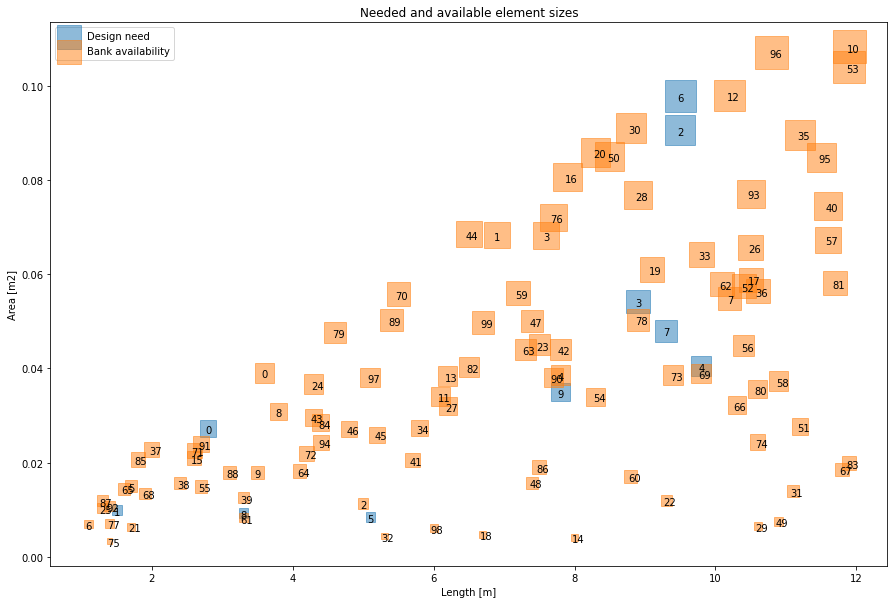

In [336]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(dsgn['Length'], dsgn['Area'], alpha=0.5, s=dsgn['Area']*10000, marker="s", label='Design need')
plt.scatter(bank['Length'], bank['Area'], alpha=0.5, s=bank['Area']*10000, marker="s", label='Bank availability')

for i in range(dsgn.shape[0]): 
  plt.annotate(i, (dsgn.loc[i, 'Length']-0.04, dsgn.loc[i, 'Area']-0.001))
for i in range(bank.shape[0]): 
  plt.annotate(i, (bank.loc[i, 'Length']-0.04, bank.loc[i, 'Area']-0.001))

plt.xlabel('Length [m]')
plt.ylabel('Area [m2]')
plt.title('Needed and available element sizes')
plt.legend(loc="upper left")
plt.show()

If we don't consider cut waste, then both solutions [1] and [1] are equaly good. 

If cut waste is considered, then [1] is selected if assignment follows order from smallest to largest, and it produces less waste; [2] is selected if assignment follows order from largest to smallest. But there is a chance that approach [1] would result in largest element not finding it's equivalent (biggest loss).

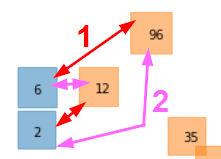

Visualize elements in 3D

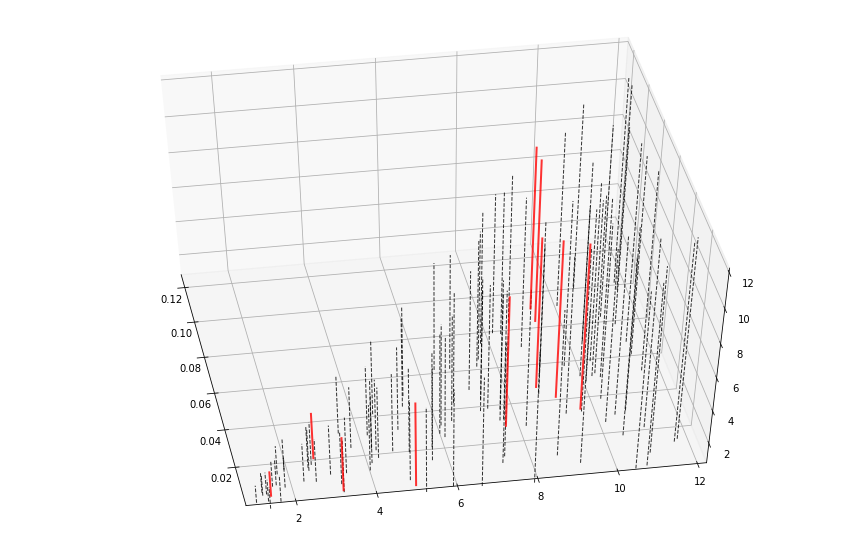

In [337]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = plt.axes(projection='3d')
ax.view_init(50, -10)

ax.set_xlim(MAX_AREA, MIN_AREA)
ax.set_ylim(MIN_LENGTH, MAX_LENGTH)
ax.set_zlim(MIN_LENGTH, MAX_LENGTH)

for i in range(bank.shape[0]):
    x = [bank.loc[i, 'Area'], bank.loc[i, 'Area']]
    y = [bank.loc[i, 'Length'], bank.loc[i, 'Length']]
    z = [0, bank.loc[i, 'Length']]
    ax.plot(x,y,z,'k--',alpha=0.8, linewidth=1)

for i in range(dsgn.shape[0]):
    x = [dsgn.loc[i, 'Area'], dsgn.loc[i, 'Area']]
    y = [dsgn.loc[i, 'Length'], dsgn.loc[i, 'Length']]
    z = [0, dsgn.loc[i, 'Length']]
    ax.plot(x,y,z, alpha=0.8, linewidth=2, color='red')

## Generate new elements
Allow for adding new (virgin) elements to the design

In [338]:
def generate_new(length, area):
  random.seed(3)
  
  if not (type(length) == int or type(length) == float) and (type(area) == int or type(area) == float):
    raise Exception('Inputs to the function must be numbers')

  return pd.DataFrame(data={
    'Length':   length,         # [m]
    'Area':     area,           # [m2]
    'Distance': NEW_DISTANCE,   # [km]
    'Price':    NEW_PRICE * length * area,  # [NOK], length * area * price (per m3)
    'LCA_GWP':  length * area * (NEW_LCA_GWP_A1_A3 + NEW_LCA_GWP_A5) + NEW_DISTANCE * TRANSPORT_LCA_GWP,   # [kgCO2e], length * area * processing_emissions + distance * transport_emissions  
    'Weight':   length * area * DENSITY,           # [kg]
    }, index=[0])

Verify by comparing bank element with new equivalent: 

In [339]:
new_eq = generate_new(bank.loc[0, 'Length'], bank.loc[0, 'Area'])
print(f"First element in the bank is {round(100-bank.loc[0, 'Price']/new_eq.loc[0,'Price']*100)}% cheaper, and has {round(100-bank.loc[0, 'LCA_GWP']/new_eq.loc[0,'LCA_GWP']*100)}% less CO2, than new product of the same size.")

First element in the bank is 50% cheaper, and has 50% less CO2, than new product of the same size.


# Optimization

## [NEW] Only new elements
This is our reference solution. All other solutions with reuse of preowned elements should outperform that reference.

In [352]:
new_set = pd.DataFrame()

import time
start_time = time.time()

for index, row in dsgn.iterrows():
  new_elem = generate_new(row['Length'], row['Area'])
  #append new element to the set:
  new_set = new_set.append(new_elem, ignore_index = True)

new_time = time.time()-start_time
print(f"Execution time: {round(new_time*1000)/1000} sec.")

print(f"If constructed from only new products, the design would have LCA-GWP {round(new_set['LCA_GWP'].sum())} kgCO2e, cost {round(new_set['Price'].sum())} NOK, and weight {round(new_set['Weight'].sum())} kg.")

Execution time: 0.038 sec.
If constructed from only new products, the design would have LCA-GWP 140 kgCO2e, cost 28435 NOK, and weight 1745 kg.


## [BRU] With brute force

Iterate through all the possibilities, and choose the best performing mapping.

In [345]:
#measure time
import time
start_time = time.time()

# sort 'dsgn' and 'new_set' by volume, from smallest to largest: 
dsgn_sorted = dsgn.loc[(dsgn.Length * dsgn.Area).sort_values().index]
new_set_sorted = new_set.loc[(new_set.Length * new_set.Area).sort_values().index]

# Create dataframe by replacing according to the mapping:
bru_set = new_set_sorted.copy()
bru_set['Bank_id'] = None
bru_set['Cut_length'] = None

for dsgn_index, dsgn_row in dsgn_sorted.iterrows():
  for bank_index, bank_row in bank.iterrows():
    # check feasibility:
    if bank_row['Length'] >= dsgn_row['Length'] and bank_row['Area'] >= dsgn_row['Area']:
      # check if element not already taken:
      if bank_index not in list(bru_set['Bank_id']):
        # check if both price and LCA are better than reference:
        if bank_row['Price'] <= new_set_sorted.loc[dsgn_index]['Price'] and bank_row['LCA_GWP'] <= new_set_sorted.loc[dsgn_index]['LCA_GWP']:
          if not bru_set.loc[dsgn_index, 'Bank_id']:
            bru_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )
            bru_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bru_set.loc[dsgn_index, 'Weight'] = bru_set.loc[dsgn_index, 'Length'] * bru_set.loc[dsgn_index, 'Area'] * DENSITY
          elif bank_row['Price'] <= bank.loc[bru_set.loc[dsgn_index, 'Bank_id']]['Price'] and bank_row['LCA_GWP'] <= bank.loc[bru_set.loc[dsgn_index, 'Bank_id']]['LCA_GWP']:
            bru_set.loc[dsgn_index, :] = bank_row.drop(labels=['Length']).append( pd.Series([bank_index, bank_row['Length']-dsgn.loc[dsgn_index,'Length']], index=['Bank_id', 'Cut_length']) )  
            bru_set.loc[dsgn_index, 'Length'] = dsgn.loc[dsgn_index,'Length']
            bru_set.loc[dsgn_index, 'Weight'] = bru_set.loc[dsgn_index, 'Length'] * bru_set.loc[dsgn_index, 'Area'] * DENSITY

bru_time = time.time()-start_time
print(f"Execution time: {round(bru_time*10000)/10000} sec.")

bru_cut_weight = (bru_set['Cut_length'] * bru_set['Area']).sum() * DENSITY
print(f"\nBrute force achieved LCA-GWP {round(bru_set['LCA_GWP'].sum())} kgCO2e, cost {round(bru_set['Price'].sum())} NOK, and weight {round(bru_set['Weight'].sum())} kg. It would also result in {round(bru_cut_weight)} kg of scrap waste.\n\n")

bru_set

Execution time: 0.1823 sec.

Brute force achieved LCA-GWP 49 kgCO2e, cost 17220 NOK, and weight 1931 kg. It would also result in 161 kg of scrap waste.




,Length,Area,Distance,Price,LCA_GWP,Weight,Bank_id,Cut_length
1,1.5,0.014460,100,92.544000,3.268806,10.649790,65.0,0.1
8,3.3,0.012482,100,164.769000,3.338113,20.225395,39.0,0.0
5,5.1,0.008408,100,343.026000,4.487358,21.053221,None,None
0,2.8,0.030842,100,468.793333,3.629856,42.401123,8.0,1.0
9,7.8,0.038575,100,1203.540000,4.334923,147.734535,4.0,0.0
4,9.8,0.044793,100,1863.402667,4.968131,215.536561,56.0,0.6
7,9.3,0.054860,100,2238.288000,5.327872,250.507218,7.0,0.9
3,8.9,0.060968,100,2219.217000,5.309572,266.421878,19.0,0.2
2,9.5,0.097955,100,3996.564000,7.015123,456.911097,12.0,0.7
6,9.5,0.107170,100,4629.744000,7.622725,499.894465,96.0,1.3


Visualize mapping

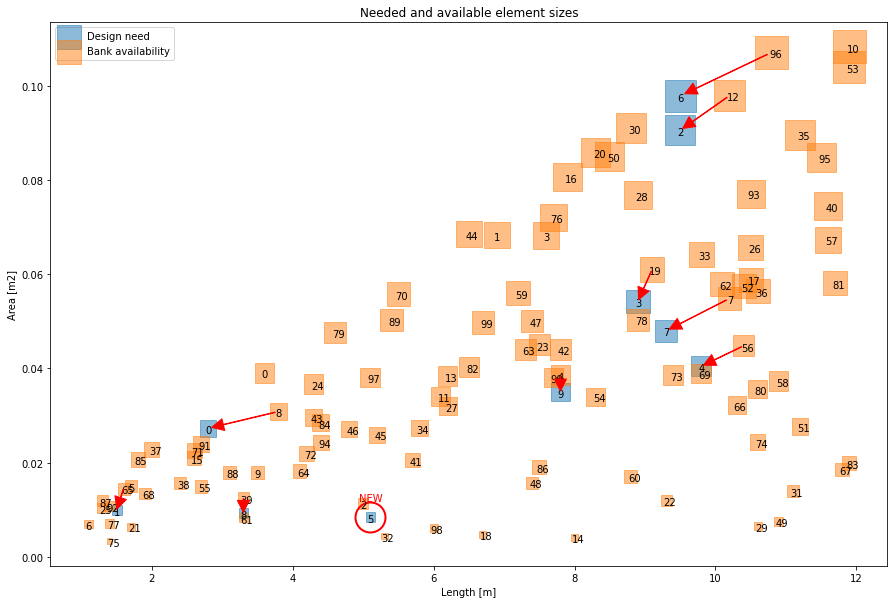

In [346]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(dsgn['Length'], dsgn['Area'], alpha=0.5, s=dsgn['Area']*10000, marker="s", label='Design need')
plt.scatter(bank['Length'], bank['Area'], alpha=0.5, s=bank['Area']*10000, marker="s", label='Bank availability')

for i in range(dsgn.shape[0]): 
  plt.annotate(i, (dsgn.loc[i, 'Length']-0.04, dsgn.loc[i, 'Area']-0.001))
for i in range(bank.shape[0]): 
  plt.annotate(i, (bank.loc[i, 'Length']-0.04, bank.loc[i, 'Area']-0.001))

for bru_index, bru_row in bru_set.iterrows():
  if bru_row['Bank_id']:
    # annotate elements to be reused
    plt.annotate("", xy=(dsgn.loc[bru_index, 'Length'], dsgn.loc[bru_index, 'Area']), xytext=(bank.loc[int(bru_row['Bank_id']),'Length'], bank.loc[int(bru_row['Bank_id']),'Area']),
              arrowprops=dict(color='r', shrink=0.05, width=0.5))  
  else:
    # annotate new elements
    plt.annotate("NEW", xy=(bru_row['Length']-0.16, bru_row['Area']+0.0035), color='r')
    plt.plot(bru_row['Length'], bru_row['Area'], 'o', ms=30, mec='r', mfc='none', mew=2)

plt.xlabel('Length [m]')
plt.ylabel('Area [m2]')
plt.title('Needed and available element sizes')
plt.legend(loc="upper left")
plt.show()

## [MAT] With matrix operatoins

Create fitness matrix with 1's if MB element is longer than DS element.

In [ ]:
# import numpy as np
# import pandas as pd

# fit = pd.DataFrame(0, index=ND_labels, columns=MB_labels)

# for i in range(len(MB)):
#     for j in range(len(ND)):
#         if ND[j] <= MB[i]:
#             fit.iloc[j,i] = 1
            
# fit

,B0,B1,B2,B3,B4
D0,0,1,1,1,1
D1,0,0,1,1,1
D2,0,0,0,0,1
D3,0,0,0,0,0


Eliminate rows with no match:

In [ ]:
# fit.drop(fit[fit.sum(axis=1) == 0].index, inplace=True)
# fit

,B0,B1,B2,B3,B4
D0,0,1,1,1,1
D1,0,0,1,1,1
D2,0,0,0,0,1


Eliminate columns with no match:

In [ ]:
# fit.drop(fit.columns[fit.sum() == 0], axis=1, inplace=True)
# fit

,B1,B2,B3,B4
D0,1,1,1,1
D1,0,1,1,1
D2,0,0,0,1


Apply mapping if only one match in a row

In [ ]:
# MB_updated

[1, 3, 4, 5, 7]

In [ ]:
# mapping

{'D0': '', 'D1': '', 'D2': '', 'D3': ''}

In [ ]:
# if (fit.sum(axis=1) == 1).sum() > 0:
#   row_id = fit[fit.sum(axis=1) == 1].index[0]
#   col_id = fit.loc[row_id].idxmax()

#   mapping[row_id] = col_id
#   col_loc = MB_labels.index(col_id)
#   row_loc = ND_labels.index(row_id)
#   MB_updated[col_loc] = MB_updated[col_loc] - ND[row_loc]

In [ ]:
# fit.loc['D2']

B1    0
B2    0
B3    0
B4    1
Name: D2, dtype: int64

In [ ]:
# fit.drop('D2', inplace=True)

In [ ]:
# fit

,B1,B2,B3,B4
D0,1,1,1,1
D1,0,1,1,1


update length mapping

In [ ]:
# for j in range( fit.shape[0] ):
#   if ND[ND_labels.index(fit.iloc[j].name)] > MB_updated[col_loc]:
#     fit.iloc[j, col_loc] = 0
# fit

IndexError: ignored

## [GEN] With genetic algorithm

In [ ]:
!pip3 install pygad
import pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# To be continued...

## [LIN] With linear programming (OR Tolls)

In [ ]:
# To be continued...

## Comparison

In [380]:
result = pd.DataFrame( 
    [
      [round(new_set['Price'].sum()), round(new_set['LCA_GWP'].sum()), round(new_set['Weight'].sum()), 0, round(new_time*1000)/1000],
      [round(bru_set['Price'].sum()), round(bru_set['LCA_GWP'].sum()), round(bru_set['Weight'].sum()), round(bru_cut_weight), round(new_time*1000)/1000]
    ],
    index=["new","bru"],
    columns = ["Price", "LCA_GWP", "Weight", "Cut_weight", "Exec.time"])

result

,Price,LCA_GWP,Weight,Cut_weight,Exec.time
new,28435,140,1745,0,0.038
bru,17220,49,1931,161,0.038
